In [1]:
import egglib
import glob 
import pandas as pd
import numpy as np
import os
import seaborn as sns

Goal: calculate nucleotide diversity per site for NLR clades using the egglib python package 

In [2]:
#gather alignments in fasta format 
directory='/global/scratch/users/chandlersutherland/e14/popgen/popgenome_test'
files = glob.glob(os.path.join(directory, "*.fas"))

In [4]:
#calculate gene wide statistics 
egglib_results=pd.DataFrame()

for fasta in files:
    clade=fasta.split('/')[-1].split('.')[0]
    aln=egglib.io.from_fasta(fasta, alphabet=egglib.alphabets.DNA)

    #convert to codon format to calculate synonymous and nonsynonymous sites (using Nei & Gojobori (Mol. #Biol. Evol. 1986 3:418-426).)
    codon=egglib.tools.to_codons(aln)
    cs = egglib.stats.CodingDiversity(codon)

    #create the compute stats object, and allow multi_hits (polyallelic structure) and the multi argument to average over multiple sites 
    ls=egglib.stats.ComputeStats()
    ls.configure(multi_hits=True, multi=False)

    #calculate Pi across the gene, and then normalize by lseff, the number of analyzed sites 
    ls.add_stats('Pi', 'lseff', 'D')
    stats=ls.process_align(aln, max_missing=0.1)
    Pi=stats['Pi']/stats['lseff']
    D=stats['D']

    #use the process_sites function to calculate Pi over just the synonymous and non-synonymous sites 
    statsS=ls.process_sites(cs.sites_S)
    statsNS=ls.process_sites(cs.sites_NS) 

    #normalize by the number of synonymous and nonsynonymous sites
    #if there are no polymorphisms at each site, return 0
    if cs.num_pol_S == 0:
        PiS=np.nan
    else:
        PiS=statsS['Pi']/cs.num_sites_S
    
    if cs.num_pol_NS == 0:
        PiNS=np.nan
    else:
        PiNS=statsNS['Pi']/cs.num_sites_NS

    egglib_results=egglib_results.append({'clade':clade, 'Pi':Pi, 'PiS':PiS, 'PiN':PiNS, 'D':D}, ignore_index=True)

In [6]:
egglib_results
egglib_results.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/egglib_pi.tsv', sep='\t')

Let's compute by domain statistics. First, read in the annotations from the pan-nlrome. Then, convert to an alignment index and take the majority vote. 

In [4]:
tbl = pd.read_table('/global/scratch/users/chandlersutherland/e14/popgen/panl-nrlome-nlr-domains.tsv', error_bad_lines=False, names=['Gene', 'read', 'length', 'source', 'code', 'domain', 'start', 'stop', 'p', 'unknown', 'date', 'interpro', 'domain_2'])

In [68]:
#what annotations are available for each clade? 
for fasta in files:
    clade=fasta.split('/')[-1].split('.')[0]
    aln=egglib.io.from_fasta(fasta, alphabet=egglib.alphabets.DNA)

    names=[]
    for i in range(0, aln.ns):
        name=aln.get_sample(i).name
        if name.startswith('ATHALIANA'):
        #using just the primary transcript
            clean=name.replace('ATHALIANA_', '6909|').replace('_1', '')+'.1'
        else:
            clean=name.replace('_', '|')
        names.append(clean)

    per_gene=tbl[tbl['Gene'].isin(names)]
    print(clade, ':', per_gene['domain'].unique())

Int11629_24_35_L_12 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int8443_258_453_R_8 : ['NB-ARC domain' 'maj_vote_coils_paircoils_nlrparser'
 'Leucine rich repeat']
Int9156_236_297_R_14 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int9687_297_427_R_29 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int12133_61 : ['NB-ARC domain' 'TIR domain' 'Leucine Rich Repeat']
Int8443_258_360_R_43 : ['NB-ARC domain' 'maj_vote_coils_paircoils_nlrparser'
 'Leucine rich repeat']
Int9687_297_557_R_19 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int11247_267_326_R_108_147_R_52_64_R_9 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat'
 'Leucine rich repeats (6 copies)']
Int14642_297_369_R_46 : ['maj_vote_coils_paircoils_nlrparser' 'NB-ARC domain']
Int8443_258_351_L_88_120_R_50 : ['NB-ARC domain' 'Leucine rich repeat'
 'maj_vote_coils_paircoils_nlrparser']
Int7765_208_251_L_43 : ['NB-ARC domain' 'maj_vote_coils_paircoils_nlrparser'
 'Leucine rich repeat']
Int10637_3

Int12194_239_292_R_56 : ['NB-ARC domain' 'TIR domain' 'Leucine Rich Repeat'
 'Mitochondrial 39-S ribosomal protein L47 (MRP-L47)'
 'maj_vote_coils_paircoils_nlrparser' 'bZIP transcription factor']
Int12974_336_623_R_7 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat'
 'maj_vote_coils_paircoils_nlrparser']
Int10172_376_495_R_128 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int11061_33_35_R_4 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int11547_65_120_L_59 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int9983_190_313_R_24 : ['Leucine Rich Repeat' 'NB-ARC domain' 'TIR domain']
Int9457_231_264_R_50 : ['NB-ARC domain' 'TIR domain' 'Leucine Rich Repeat']
Int12194_239_349_R_60 : ['NB-ARC domain' 'Leucine Rich Repeat' 'TIR domain']
Int10172_376_424_R_11 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int10637_304_546_R_11 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
Int10172_376_624_R_44 : ['TIR domain' 'NB-ARC domain' 'Leucine Rich Repeat']
I

In [5]:
#start with the easy stuff, the NB-ARC domain 
nbarc_tbl=tbl[tbl['domain']=='NB-ARC domain']

#from the fasta file, check the alignment object and return a list of gene names 
def get_names(fasta):
    aln=egglib.io.from_fasta(fasta, alphabet=egglib.alphabets.DNA)

    names=[]
    for i in range(0, aln.ns):
        name=aln.get_sample(i).name
        if name.startswith('ATHALIANA'):
        #using just the primary transcript
            clean=name.replace('ATHALIANA_', '6909|').replace('_1', '')+'.1'
        else:
            clean=name.replace('_', '|')
        names.append(clean)

    return(names)

#with those gene names, filter the annotation table 
def get_annotation(df, names):
    per_gene=df[df['Gene'].isin(names)]
    return(per_gene)

#function to reassign the index. Takes in an amino acid sequence, and iterates through. 
def reassign_index(aa_sequence):
    #generate an array of zeros the length of the protein 
    real_index=[0]*len(aa_sequence)
    #start counting at one, not standard python index 
    num=0
    
    #iterate through protein sequence, skipping the gaps  
    for aa in enumerate(aa_sequence): 
        index=aa[0]
        if aa[1] != '-':
            num=num+1
            real_index[index]=num
        if aa[1] == '-':
            real_index[index]=num 
    
    return real_index 

#function that outputs new coordinates that work for the alignment index 
def convert_coord(new_index, coord):
    #convert to a 1 based indexing 
    return [i for i, x in enumerate(new_index) if x == coord+1]

#write a function that takes in a list of genes and a df from the domain annotation file 
#and outputs the majority vote alignment coordinates for that domain 
def majority_vote(gene_list, df, fasta):
    results=pd.DataFrame()
    aln=egglib.io.from_fasta(fasta, alphabet=egglib.alphabets.DNA)
    aln.to_codons()
    prot = egglib.tools.translate(aln)

    for seq in enumerate(gene_list):
       #load sequence 
        aa_seq=prot.get_sequence(seq[0])

        #and name from pal2nal alignment
        name=prot.get_sample(seq[0])[0]

        if name.startswith('ATHALIANA'):
                #using just the primary transcript
            clean=name.replace('ATHALIANA_', '6909|').replace('_1', '')+'.1'
        else:
            clean=name.replace('_', '|')
        
        #currently skipping when there are double annotations. For better or for worse.
        if (clean in df['Gene'].unique() and len(df.loc[df['Gene']==clean])==1):
            start=df.loc[df['Gene']==clean]['start'].item()
            stop=df.loc[df['Gene']==clean]['stop'].item()

            new_index=reassign_index(aa_seq)
            new_start=convert_coord(new_index, start)
            new_stop=convert_coord(new_index, stop)
            results=results.append({'aln_start':new_start, 'aln_end':new_stop}, ignore_index=True)
        else: 
            continue 

    results['aln_start']=results['aln_start'].str[0]
    results['aln_end']=results['aln_end'].str[0]

    aln_start=results.mode(axis=0).loc[0, 'aln_start']
    aln_end=results.mode(axis=0).loc[0, 'aln_end']
    return [aln_start, aln_end]

In [6]:
#calculate the majority vote across each alignment for the nbarc coordinates 
nbarc_aa_coords=pd.DataFrame()
for fasta in files:
    clade=fasta.split('/')[-1].split('.')[0]
    gene_list=get_names(fasta)
    df=get_annotation(nbarc_tbl, gene_list)
    
    try: 
        nbcoords=majority_vote(gene_list, df, fasta)
        nbarc_aa_coords=nbarc_aa_coords.append({'clade':clade, 'nb_start':nbcoords[0], 'nb_end':nbcoords[1]}, ignore_index=True)
    except:
        print(clade, ' could not compute nbarc coords')

nbarc_aa_coords

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: `item` has been deprecated and will be removed in a future version
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: `item` has been deprecated and will be removed in a future version


Int12974_336_433_R_14  could not compute nbarc coords
Int12974_336_426_R_8  could not compute nbarc coords


,clade,nb_end,nb_start
0,Int11629_24_35_L_12,874.0,612.0
1,Int8443_258_453_R_8,437.0,157.0
2,Int9156_236_297_R_14,452.0,201.0
3,Int9687_297_427_R_29,448.0,201.0
4,Int12133_61,508.0,250.0
...,...,...,...
187,Int9156_236_291_R_7,479.0,222.0
188,Int10172_376_423_R_43,454.0,190.0
189,Int14939_40_64_R_9,451.0,167.0
190,Int11247_267_434_R_35,506.0,271.0


What are the issues with Int12974_336_433_R_14 and Int12974_336_426_R_8?

In [12]:
nbarc_tbl
a=get_names('/global/scratch/users/chandlersutherland/e14/popgen/popgenome_test/'+'Int12974_336_433_R_14'+'.pal2nal.fas')
b=get_names('/global/scratch/users/chandlersutherland/e14/popgen/popgenome_test/'+'Int12974_336_426_R_8'+'.pal2nal.fas')

get_annotation(nbarc_tbl, a) 
get_annotation(nbarc_tbl,b)

,Gene,read,length,source,code,domain,start,stop,p,unknown,date,interpro,domain_2
5742,6974|T205-R1,d7b44f6ec03836d247bf03fba1ec53ae,1619,Pfam,PF00931,NB-ARC domain,271,416,4.500000e-10,T,17-02-2017,IPR002182,NB-ARC
5745,6974|T205-R1,d7b44f6ec03836d247bf03fba1ec53ae,1619,Pfam,PF00931,NB-ARC domain,599,837,5.800000e-23,T,17-02-2017,IPR002182,NB-ARC
7593,7067|T101-R1,5a875a0d730447830136ef100a429acd,1576,Pfam,PF00931,NB-ARC domain,226,371,4.400000e-10,T,17-02-2017,IPR002182,NB-ARC
7596,7067|T101-R1,5a875a0d730447830136ef100a429acd,1576,Pfam,PF00931,NB-ARC domain,554,792,5.500000e-23,T,17-02-2017,IPR002182,NB-ARC
8958,7186|T141-R1,44b158698e9e1046ac2b93da31f5d321,1452,Pfam,PF00931,NB-ARC domain,271,416,3.900000e-10,T,17-02-2017,IPR002182,NB-ARC
8961,7186|T141-R1,44b158698e9e1046ac2b93da31f5d321,1452,Pfam,PF00931,NB-ARC domain,599,837,4.900000e-23,T,17-02-2017,IPR002182,NB-ARC
9473,7213|T228-R1,cfd8d661c4a6ff23157ad9f355aba7e0,1285,Pfam,PF00931,NB-ARC domain,271,416,3.300000e-10,T,17-02-2017,IPR002182,NB-ARC
9476,7213|T228-R1,cfd8d661c4a6ff23157ad9f355aba7e0,1285,Pfam,PF00931,NB-ARC domain,599,837,4.000000e-23,T,17-02-2017,IPR002182,NB-ARC
9813,7273|T141-R1,022ff40afafc6aa767d366823143de2f,1623,Pfam,PF00931,NB-ARC domain,271,416,4.600000e-10,T,17-02-2017,IPR002182,NB-ARC
9816,7273|T141-R1,022ff40afafc6aa767d366823143de2f,1623,Pfam,PF00931,NB-ARC domain,599,837,3.200000e-23,T,17-02-2017,IPR002182,NB-ARC


They each have double the NBARC domains. No Col-0 reps, so moving on for now. 

Time to spot check these annotations using snapgene and a few representatives. 

In [7]:
nbarc_aa_coords=nbarc_aa_coords[['clade', 'nb_start', 'nb_end']]

In [8]:
# #write a function that takes in protein alignment coordinates and clade and outputs the desired stats 
def sub_stat(row, domain):
    #load alignment, and subset by domain
    fasta='/global/scratch/users/chandlersutherland/e14/popgen/popgenome_test/'+row[0]+'.pal2nal.fas'
    clade=row[0]
    aln=egglib.io.from_fasta(fasta, alphabet=egglib.alphabets.DNA)
    aln.to_codons()
    subset=aln.extract(int(row[1]), int(row[2]))
    #print(subset.ls)
    #print(subset.fasta())
    
    #compute across subset stats
    ls=egglib.stats.ComputeStats()
    ls.configure(multi_hits=True, multi=False)
    ls.add_stats('Pi', 'lseff', 'D')
    stats=ls.process_align(subset, max_missing=0.1)
    
    lseff=stats['lseff']
    D=stats['D']
    if pd.isnull(stats['D']):
        D=np.nan
    if lseff == 0:
        Pi=np.nan
    else:
        Pi=stats['Pi']/stats['lseff']
    
    #compute per synonymous and nonsynonomous site stats 
    
    cs_subset = egglib.stats.CodingDiversity(subset)

    #use the process_sites function to calculate Pi over just the synonymous and non-synonymous sites 
    statsS=ls.process_sites(cs_subset.sites_S)
    statsNS=ls.process_sites(cs_subset.sites_NS) 

    #normalize by the number of synonymous and nonsynonymous sites
    #if there are no polymorphisms at each site, return NaN
    if cs_subset.num_pol_S == 0:
        #print('No synonymous polymorphisms. PiS is '+statsS['Pi'])
        PiS=np.nan
    else:
        PiS=statsS['Pi']/cs_subset.num_sites_S
    
    if cs_subset.num_pol_NS == 0:
        PiNS=np.nan
    else:
        PiNS=statsNS['Pi']/cs_subset.num_sites_NS
    
    return({'clade':clade, 'domain':domain, 'Pi':Pi, 'PiS':PiS, 'PiN':PiNS, 'D':D})

#sub_stat(a, 'nbarc')

In [9]:
#calculate on nbarc domain 
nbarc_domain=pd.DataFrame()

for i in range(0, len(nbarc_aa_coords)):
    row=nbarc_aa_coords.iloc[i,:]
    result=sub_stat(row, 'nbarc')
    result['start']=row[1]
    result['stop']=row[2]
    #print(result)
    nbarc_domain=nbarc_domain.append(result, ignore_index=True)

nbarc_domain

,D,Pi,PiN,PiS,clade,domain,start,stop
0,0.995868,0.033044,0.009365,0.002155,Int11629_24_35_L_12,nbarc,612.0,874.0
1,-1.175319,0.005102,0.001412,0.002743,Int8443_258_453_R_8,nbarc,157.0,437.0
2,NaN,0.000000,NaN,NaN,Int9156_236_297_R_14,nbarc,201.0,452.0
3,1.382354,0.038820,0.009925,0.017156,Int9687_297_427_R_29,nbarc,201.0,448.0
4,0.407814,0.073184,0.016387,0.030286,Int12133_61,nbarc,250.0,508.0
...,...,...,...,...,...,...,...,...
187,-1.721407,0.135631,0.030444,0.079038,Int9156_236_291_R_7,nbarc,222.0,479.0
188,1.014194,0.060861,0.014193,0.035595,Int10172_376_423_R_43,nbarc,190.0,454.0
189,0.880795,0.007825,0.002740,0.002126,Int14939_40_64_R_9,nbarc,167.0,451.0
190,1.978176,0.076645,0.014522,0.028705,Int11247_267_434_R_35,nbarc,271.0,506.0


In [23]:
#nbarc_domain.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/nbarc_pi.tsv', sep='\t')

Ok, repeat for TNL then CNL domains. 

In [10]:
tir_tbl=tbl[tbl['domain']=='TIR domain']

tir_aa_coords=pd.DataFrame()
for fasta in files:
    clade=fasta.split('/')[-1].split('.')[0]
    gene_list=get_names(fasta)
    df=get_annotation(tir_tbl, gene_list)
    
    try: 
        tircoords=majority_vote(gene_list, df, fasta)
        tir_aa_coords=tir_aa_coords.append({'clade':clade, 'tir_start':tircoords[0], 'tir_end':tircoords[1]}, ignore_index=True)
    except:
        print(clade, ' could not compute tir coords')

tir_aa_coords

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: `item` has been deprecated and will be removed in a future version
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: `item` has been deprecated and will be removed in a future version


Int8443_258_453_R_8  could not compute tir coords
Int8443_258_360_R_43  could not compute tir coords
Int14642_297_369_R_46  could not compute tir coords
Int8443_258_351_L_88_120_R_50  could not compute tir coords
Int7765_208_251_L_43  could not compute tir coords
Int14174_152_277_R_8  could not compute tir coords
Int8443_258_352_R_4  could not compute tir coords
Int8908_92_114_R_28  could not compute tir coords
Int14052_123_185_L_62  could not compute tir coords
Int7973_410_746_R_58  could not compute tir coords
Int14328_59  could not compute tir coords
Int14034_18  could not compute tir coords
Int9000_84_90_R_17  could not compute tir coords
Int14174_152_254_R_24  could not compute tir coords
Int8443_258_447_R_7  could not compute tir coords
Int8786_59  could not compute tir coords
Int12974_336_392_R_32  could not compute tir coords
Int14642_297_350_R_17  could not compute tir coords
Int14174_152_193_R_60  could not compute tir coords
Int8845_63  could not compute tir coords
Int14387_

,clade,tir_end,tir_start
0,Int11629_24_35_L_12,608.0,407.0
1,Int9156_236_297_R_14,199.0,24.0
2,Int9687_297_427_R_29,191.0,17.0
3,Int12133_61,247.0,55.0
4,Int9687_297_557_R_19,220.0,15.0
...,...,...,...
115,Int11093_76_91_R_54,190.0,13.0
116,Int9156_236_291_R_7,212.0,13.0
117,Int10172_376_423_R_43,187.0,13.0
118,Int11247_267_434_R_35,255.0,52.0


In [11]:
tir_aa_coords=tir_aa_coords[['clade', 'tir_start', 'tir_end']]

#spot check some overlapping 
print(tir_aa_coords[tir_aa_coords['clade']=='Int11629_24_35_L_12'])
print(nbarc_aa_coords[nbarc_aa_coords['clade']=='Int11629_24_35_L_12'])

print(tir_aa_coords[tir_aa_coords['clade']=='Int9687_297_427_R_29'])
print(nbarc_aa_coords[nbarc_aa_coords['clade']=='Int9687_297_427_R_29'])

                 clade  tir_start  tir_end
0  Int11629_24_35_L_12      407.0    608.0
                 clade  nb_start  nb_end
0  Int11629_24_35_L_12     612.0   874.0
                  clade  tir_start  tir_end
2  Int9687_297_427_R_29       17.0    191.0
                  clade  nb_start  nb_end
3  Int9687_297_427_R_29     201.0   448.0


In [12]:
#calculate on tir domain 
tir_domain=pd.DataFrame()

for i in range(0, len(tir_aa_coords)):
    row=tir_aa_coords.iloc[i,:]
    result=sub_stat(row, 'tir')
    result['start']=row[1]
    result['stop']=row[2]
    #print(result)
    tir_domain=tir_domain.append(result, ignore_index=True)

tir_domain

,D,Pi,PiN,PiS,clade,domain,start,stop
0,-0.340707,0.050174,0.007363,0.031431,Int11629_24_35_L_12,tir,407.0,608.0
1,-0.847866,0.005338,0.002316,NaN,Int9156_236_297_R_14,tir,24.0,199.0
2,0.083987,0.049401,0.010584,0.029318,Int9687_297_427_R_29,tir,17.0,191.0
3,-0.700440,0.050320,NaN,NaN,Int12133_61,tir,55.0,247.0
4,-2.302068,0.011845,0.003248,0.006629,Int9687_297_557_R_19,tir,15.0,220.0
...,...,...,...,...,...,...,...,...
115,0.022038,0.029160,0.006832,NaN,Int11093_76_91_R_54,tir,13.0,190.0
116,NaN,NaN,NaN,NaN,Int9156_236_291_R_7,tir,13.0,212.0
117,-0.288783,0.049945,0.008414,0.031462,Int10172_376_423_R_43,tir,13.0,187.0
118,3.239265,0.263191,0.039234,NaN,Int11247_267_434_R_35,tir,52.0,255.0


In [13]:
cc_tbl=tbl[tbl['domain']=='maj_vote_coils_paircoils_nlrparser']

cc_aa_coords=pd.DataFrame()
for fasta in files:
    clade=fasta.split('/')[-1].split('.')[0]
    gene_list=get_names(fasta)
    df=get_annotation(cc_tbl, gene_list)
    
    try: 
        cccoords=majority_vote(gene_list, df, fasta)
        cc_aa_coords=cc_aa_coords.append({'clade':clade, 'cc_start':cccoords[0], 'cc_end':cccoords[1]}, ignore_index=True)
    except:
        continue
        #print(clade, ' could not compute cc coords')

cc_aa_coords

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: `item` has been deprecated and will be removed in a future version
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: `item` has been deprecated and will be removed in a future version


,cc_end,cc_start,clade
0,62.0,28.0,Int8443_258_453_R_8
1,64.0,30.0,Int8443_258_360_R_43
2,61.0,13.0,Int14642_297_369_R_46
3,56.0,29.0,Int8443_258_351_L_88_120_R_50
4,159.0,24.0,Int7765_208_251_L_43
5,50.0,16.0,Int8443_258_352_R_4
6,56.0,36.0,Int7973_410_746_R_58
7,529.0,462.0,Int14328_59
8,63.0,29.0,Int8443_258_447_R_7
9,1157.0,1130.0,Int12974_336_392_R_32


In [14]:
cc_aa_coords=cc_aa_coords[['clade', 'cc_start', 'cc_end']]

#spot check some overlapping 
print(cc_aa_coords[cc_aa_coords['clade']=='Int14642_297_534_R_55'])
print(nbarc_aa_coords[nbarc_aa_coords['clade']=='Int14642_297_534_R_55'])

print(cc_aa_coords[cc_aa_coords['clade']=='Int8443_258_403_R_45'])
print(nbarc_aa_coords[nbarc_aa_coords['clade']=='Int8443_258_403_R_45'])

                    clade  cc_start  cc_end
46  Int14642_297_534_R_55      13.0    65.0
                     clade  nb_start  nb_end
181  Int14642_297_534_R_55     169.0   461.0
                   clade  cc_start  cc_end
42  Int8443_258_403_R_45      27.0    66.0
                    clade  nb_start  nb_end
172  Int8443_258_403_R_45     159.0   437.0


In [15]:
#calculate on cc domain 
cc_domain=pd.DataFrame()

for i in range(0, len(cc_aa_coords)):
    row=cc_aa_coords.iloc[i,:]
    result=sub_stat(row, 'cc')
    result['start']=row[1]
    result['stop']=row[2]
    #print(result)
    cc_domain=cc_domain.append(result, ignore_index=True)

cc_domain

,D,Pi,PiN,PiS,clade,domain,start,stop
0,NaN,0.000000,NaN,NaN,Int8443_258_453_R_8,cc,28.0,62.0
1,0.089141,0.007231,NaN,0.011655,Int8443_258_360_R_43,cc,30.0,64.0
2,-1.121408,0.000926,NaN,NaN,Int14642_297_369_R_46,cc,13.0,61.0
3,-0.503168,0.096566,0.011853,0.003233,Int8443_258_351_L_88_120_R_50,cc,29.0,56.0
4,NaN,NaN,NaN,NaN,Int7765_208_251_L_43,cc,24.0,159.0
5,NaN,0.000000,NaN,NaN,Int8443_258_352_R_4,cc,16.0,50.0
6,0.675578,0.069737,NaN,NaN,Int7973_410_746_R_58,cc,36.0,56.0
7,-0.782923,0.030697,0.000961,0.001640,Int14328_59,cc,462.0,529.0
8,NaN,0.000000,NaN,NaN,Int8443_258_447_R_7,cc,29.0,63.0
9,-1.806599,0.106959,NaN,NaN,Int12974_336_392_R_32,cc,1130.0,1157.0


Daniil ran LRRpredictor on the panNLRome NLRs. Use this to get a better annotation across the clades than the PFAM.

In [102]:
#read in pan nlrome and convert to appropriate format for functions 
pan_lrr_pred=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/Athaliana_panNLRome_lrrpred.txt', sep='\t', index_col=False)
pan_lrr_pred=pan_lrr_pred[pan_lrr_pred['#Prot']!='#Prot']
pan_lrr_pred['pos'] = pd.to_numeric(pan_lrr_pred['pos'])
pan_lrr_pred.dtypes
rough=pan_lrr_pred.groupby('#Prot').pos.agg(['min', 'max']).reset_index()
to_test=rough.rename(columns={'#Prot':'Gene', 'min':'start', 'max':'stop'})
to_test['Gene']=to_test['Gene'].str.replace('_', '|')

#read in Col0 and cleanup 
lrr_pred=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/col-0-nlrome.txt', sep='\t')
col=lrr_pred.groupby('annotation').start.agg(['min', 'max']).reset_index()
col=col.rename(columns={'annotation':'Gene', 'min':'start', 'max':'stop'})
col['Gene']=col['Gene'].str.replace('Athaliana_', '6909|').str.replace('_1', '.1')
col0=col[col['Gene'].str.endswith('.1')]

lrr_tbl=pd.concat([to_test, col0])

In [110]:
lrr_aa_coords=pd.DataFrame()
for fasta in files:
    clade=fasta.split('/')[-1].split('.')[0]
    gene_list=get_names(fasta)
    df=get_annotation(lrr_tbl, gene_list)
    
    try: 
        lrrcoords=majority_vote(gene_list, df, fasta)
        lrr_aa_coords=lrr_aa_coords.append({'clade':clade, 'lrr_start':lrrcoords[0], 'lrr_end':lrrcoords[1]}, ignore_index=True)
    except:
        print(clade, ' could not compute lrr coords')
        continue

lrr_aa_coords

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: `item` has been deprecated and will be removed in a future version
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: `item` has been deprecated and will be removed in a future version


Int10547_34_50_L_17  could not compute lrr coords


,clade,lrr_end,lrr_start
0,Int11629_24_35_L_12,1450.0,985.0
1,Int8443_258_453_R_8,831.0,512.0
2,Int9156_236_297_R_14,1000.0,537.0
3,Int9687_297_427_R_29,865.0,572.0
4,Int12133_61,1175.0,616.0
...,...,...,...
188,Int9156_236_291_R_7,1161.0,569.0
189,Int10172_376_423_R_43,864.0,561.0
190,Int14939_40_64_R_9,853.0,529.0
191,Int11247_267_434_R_35,1037.0,652.0


In [111]:
#calculate on lrr domain 
lrr_aa_coords=lrr_aa_coords[['clade', 'lrr_start', 'lrr_end']]
lrr_domain=pd.DataFrame()

for i in range(0, len(lrr_aa_coords)):
    row=lrr_aa_coords.iloc[i,:]
    result=sub_stat(row, 'lrr')
    result['start']=row[1]
    result['stop']=row[2]
    #print(result)
    lrr_domain=lrr_domain.append(result, ignore_index=True)

lrr_domain

,D,Pi,PiN,PiS,clade,domain,start,stop
0,-0.785187,0.003209,0.000257,0.004707,Int11629_24_35_L_12,lrr,985.0,1450.0
1,-1.310092,0.001567,0.000341,0.001114,Int8443_258_453_R_8,lrr,512.0,831.0
2,-0.394391,0.001828,NaN,NaN,Int9156_236_297_R_14,lrr,537.0,1000.0
3,0.112003,0.061202,NaN,NaN,Int9687_297_427_R_29,lrr,572.0,865.0
4,0.821077,0.120778,0.016635,0.042113,Int12133_61,lrr,616.0,1175.0
...,...,...,...,...,...,...,...,...
188,-1.594412,0.073193,0.019072,0.045823,Int9156_236_291_R_7,lrr,569.0,1161.0
189,-2.065756,0.063459,0.020511,0.035699,Int10172_376_423_R_43,lrr,561.0,864.0
190,-1.637466,0.053363,0.011537,0.017598,Int14939_40_64_R_9,lrr,529.0,853.0
191,0.796276,0.111346,0.028403,0.019012,Int11247_267_434_R_35,lrr,652.0,1037.0


Add all domains together and export to tsv. The start and stop refer to the alignment coordinates. 

In [112]:
domains=[nbarc_domain, cc_domain, tir_domain, lrr_domain]
domain_level=pd.concat(domains)
domain_level
domain_level.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/domain_level_pi.tsv', sep='\t')

In [16]:
#domain_level=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/domain_level_pi.tsv', sep='\t').drop('Unnamed: 0', axis=1)

,D,Pi,PiN,PiS,clade,domain
147,-0.73335,0.040273,0.006574,0.030687,Int14387_212_343_R_44,nbarc


Complement this analysis with sliding window calculation

In [120]:
#rpp13 sliding window 
aln = egglib.io.from_fasta('/global/scratch/users/chandlersutherland/e14/popgen/clades/Int14387_212_343_R_44/popgenome/Int14387_212_343_R_44.pal2nal.fas', alphabet=egglib.alphabets.DNA)

#convert to codon format to calculate synonymous and nonsynonymous sites (using Nei & Gojobori (Mol. #Biol. Evol. 1986 3:418-426).)
codon=egglib.tools.to_codons(aln)
codon.ls

#print(codon.get_sequence(0)[0])

window_num=-1
rpp13_window=pd.DataFrame()
for window in aln.slider(100, 25):
    #window.get_sequence(0)[0:100]
    window_num += 1
    ls=egglib.stats.ComputeStats()
    ls.configure(multi_hits=True, multi=False)

    #calculate Pi across the gene, and then normalize by lseff, the number of analyzed sites 
    ls.add_stats('Pi', 'lseff', 'D')
    stats=ls.process_align(window, max_missing=0.1)
    if stats['lseff'] == 0:
        Pi=np.nan
    else:
        Pi=stats['Pi']/stats['lseff']
    D=stats['D']
    rpp13_window=rpp13_window.append({'window_num':window_num, 'Pi':Pi, 'D':D}, ignore_index=True)

rpp13_window



,D,Pi,window_num
0,0.197385,0.017262,0.0
1,0.254430,0.020063,1.0
2,0.198916,0.022125,2.0
3,0.151519,0.019387,3.0
4,0.290183,0.010338,4.0
...,...,...,...
97,1.256431,0.193493,97.0
98,0.510968,0.212958,98.0
99,-1.516574,0.086239,99.0
100,NaN,NaN,100.0


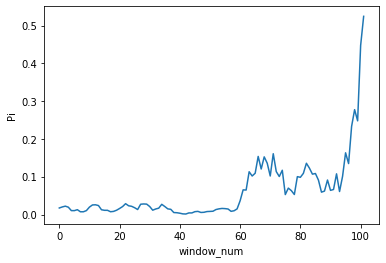

In [119]:
rpp13_window['Pi_4'] = rpp13_window.Pi.rolling(4).mean().shift(-3)

# Time series plot with Seaborn lineplot()
# sns.lineplot(x="window_num", y="Pi", 
#             data=rpp13_window, ci=None)
# axis labels
# plt.xlabel("window num", size=14)
# plt.ylabel("Pi", size=14)
sns.lineplot(x="window_num", y="Pi", 
            data=rpp13_window, ci=None)

In [121]:
window=range(0, 867, 33)
fake_annotations=pd.DataFrame()
for i in range(0, 86):
    fake_annotations=fake_annotations.append({'start':0+i*10, 'stop':33+i*10, 'clade':'Int14387_212_343_R_44'}, ignore_index=True)
fake_annotations

#calculate on cc domain 
rpp13_window=pd.DataFrame()

for i in range(0, len(fake_annotations)):
    row=fake_annotations.iloc[i,:]
    result=sub_stat(row, 'window')
    result['start']=row[1]
    result['stop']=row[2]
    rpp13_window=rpp13_window.append(result, ignore_index=True)

rpp13_window

,D,Pi,PiN,PiS,clade,domain,start,stop
0,0.197385,0.052310,0.010781,0.029923,Int14387_212_343_R_44,window,0.0,33.0
1,0.254430,0.060798,0.011147,0.030698,Int14387_212_343_R_44,window,10.0,43.0
2,0.198916,0.067045,0.014137,0.029187,Int14387_212_343_R_44,window,20.0,53.0
3,-0.049741,0.041002,0.006384,0.028475,Int14387_212_343_R_44,window,30.0,63.0
4,0.274079,0.031136,0.006233,0.024889,Int14387_212_343_R_44,window,40.0,73.0
...,...,...,...,...,...,...,...,...
81,2.455599,0.365785,NaN,NaN,Int14387_212_343_R_44,window,810.0,843.0
82,-0.642031,0.180586,NaN,NaN,Int14387_212_343_R_44,window,820.0,853.0
83,NaN,NaN,NaN,NaN,Int14387_212_343_R_44,window,830.0,863.0
84,NaN,NaN,NaN,NaN,Int14387_212_343_R_44,window,840.0,873.0


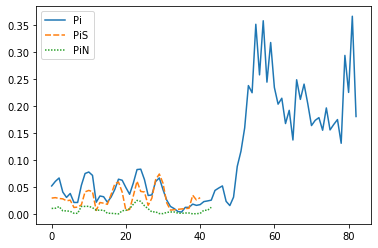

In [122]:
# no_na=rpp13_window.dropna(axis=0)
# no_na['Pi'] = no_na['Pi'].astype('float')
# sns.lineplot(x='start', y="Pi", 
#             data=no_na, ci=None)

#sns.lineplot(x='start', y=['Pi', 'PiS','PiN'], data=rpp13_window, ci=None)
sns.lineplot(data=rpp13_window[['Pi', 'PiS', 'PiN']])
#sns.lineplot(data=rpp13_window[['D']])

In [19]:
base='/global/scratch/users/chandlersutherland/e14/NLRCladeFinder/Atha_NLRome/'
gene_table=base+"Atha_NLRome_GeneTable.txt"
gene=pd.read_csv(gene_table,sep = '\t')

clades=gene['Clade'].unique()

In [34]:
#function that takes in a clade name, and evaluates Pi, PiS, PiNS, and D across sliding windows of window size 33 codons and step size 10 codons 
#outputs a dataframe with the results across the codon windows 
def my_slider(clade, window, step):
    #get codon length 
    test_results=pd.DataFrame()
    path='/global/scratch/users/chandlersutherland/e14/popgen/popgenome_test/'+clade+'.pal2nal.fas'
    if os.path.isfile(path): 
        aln = egglib.io.from_fasta(path, alphabet=egglib.alphabets.DNA)
        codon_length=aln.ls/3

        #generate a fake annotations dataframe based on this length 
        fake_annotations=pd.DataFrame()
        for i in range(0, int(codon_length/step)):
            fake_annotations=fake_annotations.append({'start':0+i*step, 'stop':window+i*step, 'clade':clade}, ignore_index=True)
        
        #fake_annotations.iloc[len(fake_annotations)-1,2]=int(codon_length)
    
        for i in range(0, len(fake_annotations)):
            row=fake_annotations.iloc[i,:]
            result=sub_stat(row, 'window')
            result['start']=row[1]
            result['stop']=row[2]
            result['length']=codon_length
            test_results=test_results.append(result, ignore_index=True)
        return test_results 
    
    else:
        print('no alignment file for '+clade)
    
my_slider(clades[0], 50, 25)

,D,Pi,PiN,PiS,clade,domain,length,start,stop
0,NaN,0.000000,NaN,NaN,Int7764_78_107_R_21,window,892.0,0.0,50.0
1,-1.163564,0.001905,NaN,0.002857,Int7764_78_107_R_21,window,892.0,25.0,75.0
2,-0.514835,0.023048,0.003530,0.023434,Int7764_78_107_R_21,window,892.0,50.0,100.0
3,0.391912,0.055810,0.013904,0.035808,Int7764_78_107_R_21,window,892.0,75.0,125.0
4,1.092207,0.044952,0.014864,0.015403,Int7764_78_107_R_21,window,892.0,100.0,150.0
5,0.409125,0.025429,0.005493,NaN,Int7764_78_107_R_21,window,892.0,125.0,175.0
6,0.858749,0.035714,0.005557,0.014986,Int7764_78_107_R_21,window,892.0,150.0,200.0
7,0.745144,0.034667,0.010508,0.015133,Int7764_78_107_R_21,window,892.0,175.0,225.0
8,-0.163693,0.026286,0.010050,0.003319,Int7764_78_107_R_21,window,892.0,200.0,250.0
9,0.313374,0.018667,0.006859,0.003425,Int7764_78_107_R_21,window,892.0,225.0,275.0


In [36]:
#apply to all alignments and make a mega dataframe 
concat_slider=pd.DataFrame()
for clade in clades:
    result=my_slider(clade, 50, 25)
    concat_slider=pd.concat([concat_slider, result])

concat_slider

no alignment file for Int7765_208_264_R_3
no alignment file for Int7973_410_710_R_3
no alignment file for Int9156_236_311_R_2
no alignment file for Int9457_231_368_R_1
no alignment file for Int9687_297_464_R_2
no alignment file for Int10637_304_381_R_3
no alignment file for Int11093_76_144_R_3
no alignment file for Int11170_39_55_R_2
no alignment file for Int11247_267_326_R_108_147_R_52_90_R_2
no alignment file for Int11708_423_518_R_3
no alignment file for Int12432_284_328_R_3
no alignment file for Int12730_93_42_R_1
no alignment file for Int12974_336_82_R_1
no alignment file for Int12974_336_105_R_1
no alignment file for Int13511_119_3_R_1
no alignment file for Int14979_63_56_R_1
no alignment file for Int15041_179_64_R_1
no alignment file for Int15041_179_68_R_1


,D,Pi,PiN,PiS,clade,domain,length,start,stop
0,NaN,0.000000,NaN,NaN,Int7764_78_107_R_21,window,892.0,0.0,50.0
1,-1.163564,0.001905,NaN,0.002857,Int7764_78_107_R_21,window,892.0,25.0,75.0
2,-0.514835,0.023048,0.003530,0.023434,Int7764_78_107_R_21,window,892.0,50.0,100.0
3,0.391912,0.055810,0.013904,0.035808,Int7764_78_107_R_21,window,892.0,75.0,125.0
4,1.092207,0.044952,0.014864,0.015403,Int7764_78_107_R_21,window,892.0,100.0,150.0
...,...,...,...,...,...,...,...,...,...
50,-1.030536,0.019608,NaN,0.038820,Int14034_18,window,1377.0,1250.0,1300.0
51,-1.761522,0.013431,NaN,0.166667,Int14034_18,window,1377.0,1275.0,1325.0
52,0.296148,0.013235,NaN,NaN,Int14034_18,window,1377.0,1300.0,1350.0
53,0.547174,0.021176,NaN,NaN,Int14034_18,window,1377.0,1325.0,1375.0


In [37]:
#concat_slider.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/pi_slider_33.csv')
concat_slider.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/pi_slider_50.csv')

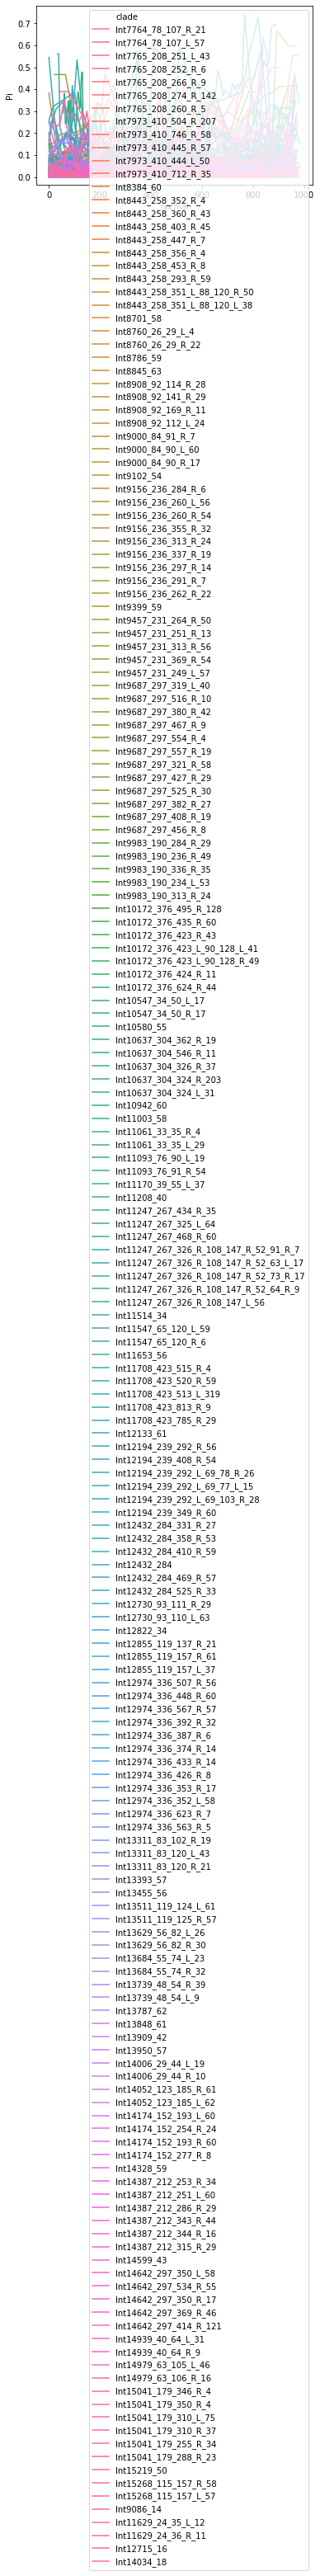

In [39]:
concat_slider['normal']=concat_slider['start']/concat_slider['length']*1000
concat_slider

sns.lineplot(x='normal', y='Pi', hue='clade', data=concat_slider)

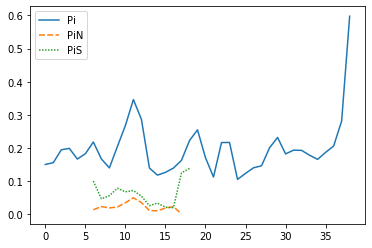

In [40]:
sns.lineplot(data=concat_slider[concat_slider['clade']=='Int7765_208_274_R_142'][['Pi', 'PiN', 'PiS']])

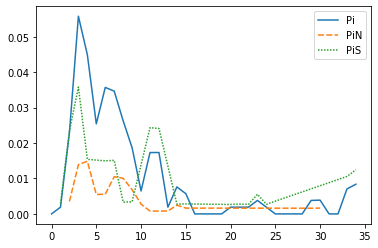

In [41]:
sns.lineplot(data=concat_slider[concat_slider['clade']=='Int7764_78_107_R_21'][['Pi', 'PiN', 'PiS']])